# Benchmarking linear N-dimensional interpolators

*Rationale*

A fast and simple interpolation routine is needed in the Stochastic Dynamic Programming algorithm.
The "fast and simple" requirement leads to choose the *linear interpolation* method.

The method needs to be applicable to N-dimensional input, i.e. to interpolate a scalar function :

$$ x\mapsto f(x)\in\mathbb{R} ,\quad x\in D \subset \mathbb{R}^n$$

where the dimension $n$ will be *in practice* less than 3 or 4.

We here try to evaluate what routines can be found "off-the-shelf".

*References*

* `scipy.interpolate` doc http://docs.scipy.org/doc/scipy/reference/interpolate.html
* `scipy.ndimage` doc 

Update February 2015: add [scipy.interpolate.RegularGridInterpolator](http://docs.scipy.org/doc/scipy-dev/reference/generated/scipy.interpolate.RegularGridInterpolator.html) in the benchmark (added in `scipy` 0.14, released in May 2014)

In [26]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [27]:
from scipy.interpolate import (
    LinearNDInterpolator, RectBivariateSpline,
    RegularGridInterpolator, CloughTocher2DInterpolator)
from scipy.ndimage import map_coordinates

In [28]:
# Tweak how images are plotted with imshow
mpl.rcParams['image.interpolation'] = 'none' # no interpolation
mpl.rcParams['image.origin'] = 'lower' # origin at lower left corner
mpl.rcParams['image.cmap'] = 'RdBu_r'

## 1) Define a simple interpolation problem

In [29]:
def f_2d(x,y):
    '''a function with 2D input to interpolate on [0,1]'''
    twopi = 2*pi
    return np.exp(-x)*np.cos(x*2*pi)*np.sin(y*2*pi)

# quick check :
f_2d(0,0.25)

1.0

In [30]:
def f_3d(x,y,z):
    '''a function with 3D input to interpolate on [0,1]'''
    twopi = 2*pi
    return np.sin(x*2*pi)*np.sin(y*2*pi)*np.sin(z*2*pi)

# quick check :
f_3d(0.25,0.25,0.25)

1.0

#### Build the 2D and 3D data grids

(500, 501)

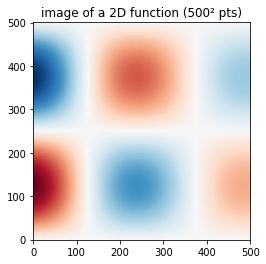

In [65]:
Ndata = 500
xgrid = np.linspace(0,1, Ndata)
ygrid = np.linspace(0,1, Ndata+1) # use a slighly different size to check differences
zgrid = np.linspace(0,1, Ndata+2)

f_2d_grid = f_2d(xgrid.reshape(-1,1), ygrid)

plt.imshow(f_2d_grid.T)
plt.title(u'image of a 2D function ({}² pts)'.format(Ndata));

f_2d_grid.shape

The 3D case

In [32]:
f_3d_grid = f_3d(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)
f_3d_grid.shape

(500, 501, 502)

## 2) Use interpolators

Try several interpolation routines.

Notice how each routine has its special way (API) to
 
1. build the interpolator (instanciation)
2. call the interpolator (evaluation)

In [66]:
# Define the grid to interpolate on :
Ninterp = 10000
xinterp = np.linspace(0,1, Ninterp)
yinterp = np.linspace(0,1, Ninterp+1) # use a slighly different size to check differences
zinterp = np.linspace(0,1, 5) # small dimension to avoid size explosion
X2, Y2 = np.meshgrid(xinterp,yinterp)
xy_int = np.column_stack((X2.flatten(), Y2.flatten()))

### a) LinearNDInterpolator

`LinearNDInterpolator` uses an *unstructured data* which is provided as a list of points. There is also a cousin : `NearestNDInterpolator`

`LinearNDInterpolator(points, values)`
([documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html))

**Performance** : 

* instanciation : 20 ms for 50^2 input pts, 4 s for 500^2 input pts,
 
* evaluation : 170 ms for 50^2 input pts & 1000^2 output pts, 300 ms for 500^2 input pts & 1000^2 output pts, 17 s for 50^2 and 10000^2, 18 s for 500^2 pts input and 100 Mpts output.

In [67]:
# Build data for the interpolator
points_x, points_y = np.broadcast_arrays(xgrid.reshape(-1,1), ygrid)
points = np.vstack((points_x.flatten(),
                    points_y.flatten())).T
values = f_2d_grid.flatten()

In [44]:
# Build
%timeit f_2d_interp = LinearNDInterpolator(points, values)

23.5 ms ± 702 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
f_2d_interp = LinearNDInterpolator(points, values)

In [69]:
# Evaluate
%timeit f_2d_interp(xy_int)

18 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


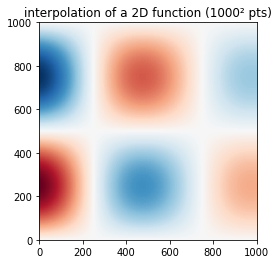

In [64]:
# Display
plt.imshow(f_2d_interp(xinterp.reshape(-1,1), yinterp).T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));

The 3D case : __terrible performance !__

In [15]:
# Build data for the interpolator
points_x, points_y, points_z = np.broadcast_arrays(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)
points = np.vstack((points_x.flatten(),
                    points_y.flatten(),
                    points_z.flatten()
                  )).T
values = f_3d_grid.flatten()
points.shape

(132600, 3)

In [16]:
%time f_3d_interp = LinearNDInterpolator(points, values) 

Wall time: 28.3 s


In [36]:
f_3d_interp = LinearNDInterpolator(points, values)

In [37]:
# Evaluate:
%time f_3d_interp(xinterp.reshape(-1,1), np.linspace(0,1,5), 0.25);

CPU times: user 2min 44s, sys: 0 ns, total: 2min 44s
Wall time: 2min 44s


array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   6.23317279e-03,   7.64852773e-19,
         -6.23317279e-03,  -1.53553034e-18],
       [  0.00000000e+00,   1.24663456e-02,   1.52970555e-18,
         -1.24663456e-02,  -3.07106068e-18],
       ..., 
       [  0.00000000e+00,  -1.25138148e-02,  -1.53553034e-18,
          1.25138148e-02,   3.07106068e-18],
       [  0.00000000e+00,  -6.25690738e-03,  -7.67765169e-19,
          6.25690738e-03,   1.53553034e-18],
       [  0.00000000e+00,  -2.44098405e-16,  -2.99525375e-32,
          2.44098405e-16,   5.99050750e-32]])

Interpolation on a slice along the x-axis, just to check that it works.

In [38]:
f_3d_interp_grid = f_3d_interp(xinterp.reshape(-1,1,1), 0.25, 0.25)

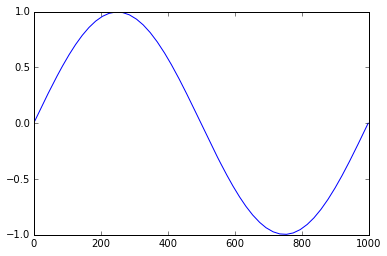

In [40]:
plt.plot(f_3d_interp_grid.flatten());

### b) RectBivariateSpline (scipy.interpolate)

*for 2D interpolation <span style='color:red;'>only</span> !*

`RectBivariateSpline(x, y, z, bbox=[None, None, None, None], kx=3, ky=3, s=0)`
([documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html))

* x,y : 1-D arrays of coordinates in strictly ascending order.
* z :  2-D array of data with shape (x.size,y.size).

**Performance**

* instanciation : 0.2 ms for 50x50 pts, 20 ms for 500x500 pts.
* evaluation (to grid): 21 ms for 50^2 pts in and 1 Mpts out, 21 ms for 500^2 pts in and 1 Mpts out, 2.1 s for 50^2 or 500^2 pts in and 100 Mpts out.
* evaluation (to points): 170 ms for 50^2 pts in and 1 Mpts out, 500 ms for 500^2 pts in and 1 Mpts out, 17 s for 50^2 pts in and 100 Mpts out, 50 s for 500^2 pts in and 100 Mpts out.

In [19]:
%%timeit # Build
f_2d_interp = RectBivariateSpline(xgrid, ygrid, f_2d_grid, s=1)

1.3 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
f_2d_interp = RectBivariateSpline(xgrid, ygrid, f_2d_grid)

In [21]:
%%timeit # Evaluate
f_2d_interp(xinterp, yinterp)

21.1 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


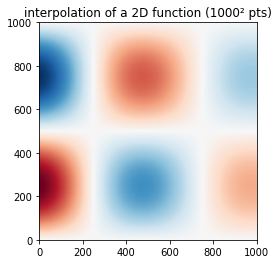

In [22]:
# Display
plt.imshow(f_2d_interp(xinterp, yinterp).T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));

### c) map_coordinates (scipy.ndimage)

notice that this method has no separation between _instanciation_ and _evaluation_ !

`map_coordinates(input, coordinates, output=None, order=3, mode='constant', cval=0.0, prefilter=True)`
([documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.interpolation.map_coordinates.html))


**Performance** : 

* 56 ms for 50^2 or 500^2 pts in and 1 Mpts out), 1.5 s for 50^2 pts in and 100 Mpts out, 5.8 s for 500^2 pts in and 100 Mpts out.
* 511 ms (5 Mpts in 3D)

In [24]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y = np.broadcast_arrays(xinterp.reshape(-1,1), yinterp)
coord = np.vstack((points_x.flatten()*(len(xgrid)-1) , # a weird formula !
                   points_y.flatten()*(len(ygrid)-1)))
coord.shape

(2, 1001000)

In [25]:
%%timeit # Build and Evaluate
f_2d_interp = map_coordinates(f_2d_grid, coord, order=3)
# Reshape
f_2d_interp = f_2d_interp.reshape(len(xinterp), len(yinterp))

123 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


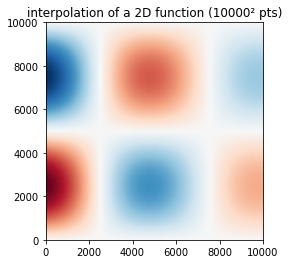

In [125]:
# Display 
f_2d_interp = map_coordinates(f_2d_grid, coord, order=1).reshape(len(xinterp), len(yinterp))

plt.imshow(f_2d_interp.T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));

The 3D case

In [88]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten()*(len(xgrid)-1), # a weird formula !
                   points_y.flatten()*(len(ygrid)-1),
                   points_z.flatten()*(len(zgrid)-1)
                   ))
coord.shape

(3, 5005000)

In [89]:
%%timeit # Build and Evaluate
f_3d_interp = map_coordinates(f_3d_grid, coord, order=1)
# Reshape
f_3d_interp = f_3d_interp.reshape(len(xinterp), len(yinterp), len(zinterp))

653 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
f_3d_interp = map_coordinates(f_3d_grid, coord, order=1)
f_3d_interp = f_3d_interp.reshape(len(xinterp), len(yinterp), len(zinterp))
f_3d_interp.shape

(1000, 1001, 5)

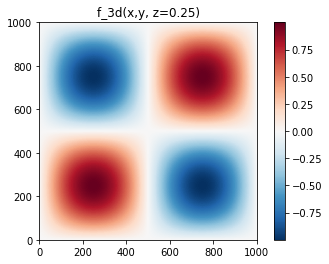

In [91]:
n_z = 1
plt.imshow(f_3d_interp[:,:,n_z])
plt.title('f_3d(x,y, z={:.2f})'.format(zinterp[n_z]))
plt.colorbar();

### e) RegularGridInterpolator (scipy.interpolate, starting v0.14)

[documentation](http://docs.scipy.org/doc/scipy-dev/reference/generated/scipy.interpolate.RegularGridInterpolator.html)

actual interpolation code: https://github.com/scipy/scipy/blob/master/scipy/interpolate/interpolate.py#L1577 (pure Python, no Cython involved!)

API:

`RegularGridInterpolator(points, values, [...])`
    
* `points`: tuple of ndarray of float, with shapes *(m1, ), ..., (mn, )*.  
  → The points defining the regular grid in n dimensions.
* `value`: array_like, shape *(m1, ..., mn, ...)*.  
  → The data on the regular grid in n dimensions.


**Performance**

* 0.022 ms for instanciation, 240 ms for evaluation (1Mpts); 0.026 ms + 260 ms for 500x500 pts,
* in 2.8 s in 3D (5 Mpts), 3.4 s for 3d

In [127]:
%%timeit # Instanciate the interpolator
f_2d_interp = RegularGridInterpolator((xgrid, ygrid), f_2d_grid)

24.1 µs ± 490 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [128]:
f_2d_interp = RegularGridInterpolator((xgrid, ygrid), f_2d_grid)

In [129]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y = np.broadcast_arrays(xinterp.reshape(-1,1), yinterp)
coord = np.vstack((points_x.flatten(),
                   points_y.flatten()))
coord.shape

(2, 100010000)

In [ ]:
%%timeit # Interpolate
f_2d_interp_res = f_2d_interp(coord.T).reshape(len(xinterp), len(yinterp))

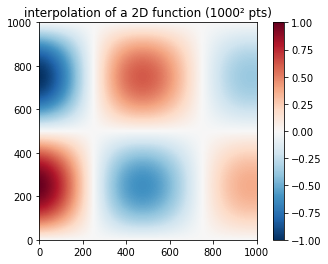

In [103]:
# Display 

f_2d_interp_res = f_2d_interp(coord.T).reshape(len(xinterp), len(yinterp))

plt.imshow(f_2d_interp_res.T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));
plt.colorbar();

#### The 3D case

In [104]:
f_3d_interp = RegularGridInterpolator((xgrid, ygrid, zgrid), f_3d_grid)

In [105]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten(), # a weird formula !
                   points_y.flatten(),
                   points_z.flatten()
                   ))
coord.shape

(3, 5005000)

In [106]:
%%timeit # Interpolate
f_3d_interp_res = f_3d_interp(coord.T).reshape(len(xinterp), len(yinterp), len(zinterp))

3.36 s ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
